## Setting up

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -q gwpy
# %rm -rf /content/some
!pip install ninja
!pip install imageio-ffmpeg
!pip install -U -q PyDrive
!pip install lpips
!pip install pytorch_msssim
!pip install pytorch-ignite
!pip install dlib

# from google.colab import files, drive

%mkdir raw_images
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models


!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 1.46 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch/pretrained_models/stylegan2-ada-pytorch
Cloning into 'stylegan2_models'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 57 (delta 14), reused 48 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 25.54 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/stylegan2-ada-pytorch/pretrained_models/stylegan2-ada-pytorch/pretrained_models
--2024-04-23 06:48:21--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.

In [10]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1cUv_reLE6k3604or78EranS7XzuVMWeO'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('e4e_ffhq_encode.pt')
%cd ..

/content/stylegan2-ada-pytorch/pretrained_models/stylegan2-ada-pytorch


In [11]:
%%capture
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt

from stylegan2_models.arcface_model import get_model
import torch.nn.functional as F
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

In [12]:
import os
import requests
from shutil import copyfileobj

if not os.path.exists('/content/data'):
    os.makedirs('/content/data')

subfolders = ['trump', 'biden', 'harris', 'pence', 'johnson']
for subfolder in subfolders:
    if not os.path.exists(os.path.join('/content/data', subfolder)):
        os.makedirs(os.path.join('/content/data', subfolder))

def download_image(url, destination):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            copyfileobj(response.raw, file)
    else:
        print(f"Failed to download image from {url}")

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [14]:
urls_trump = ["https://imgs.search.brave.com/20rY0LtMEB_Z8EG370E1lATDWISCj0KkSEizU6I6PnY/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS1jbGRucnkucy1u/YmNuZXdzLmNvbS9p/bWFnZS91cGxvYWQv/dF9maXQtNzYwdyxm/X2F1dG8scV9hdXRv/OmJlc3Qvcm9ja2Nt/cy8yMDI0LTAzLzI0/MDMyOS10cnVtcC1j/aC0xNzAxLTQwZDcz/MC5qcGc", "https://imgs.search.brave.com/t7YqHOgKxq3lE0Fr5j_CrE06V1E_gPjETtAEA2vw-vc/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS1jbGRucnkucy1u/YmNuZXdzLmNvbS9p/bWFnZS91cGxvYWQv/dF9mb2NhbC03NTh4/Mzc5LGZfYXV0byxx/X2F1dG86YmVzdC9y/b2NrY21zLzIwMjQt/MDMvMjQwMzI3LWRv/bmFsZC10cnVtcC1l/dy0xMjI1cC1mZDRh/ODkuanBn", "https://imgs.search.brave.com/gytT7amL1kPDCYGPL16NROyw9jHyL0ZPp-Kr7PBTees/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZXR0eWltYWdl/cy5jb20vaWQvNDg4/MjI2MzIyL3Bob3Rv/L2RhbGxhcy10eC1y/ZXB1YmxpY2FuLXBy/ZXNpZGVudGlhbC1j/YW5kaWRhdGUtZG9u/YWxkLXRydW1wLXNw/ZWFrcy1kdXJpbmct/YS1jYW1wYWlnbi1y/YWxseS1hdC10aGUu/anBnP3M9NjEyeDYx/MiZ3PTAmaz0yMCZj/PS1Hak9QZ09PNGE0/a2NOeW9ZZV9VcVh5/TVlieHdaekxwZVVu/QmQtLTNMckU9"]
urls_biden = ["https://imgs.search.brave.com/rQcl8aERtl2ow4KEB2wG7xt0jOQosbJBqDt5Q2xGbXQ/rs:fit:860:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy82/LzY4L0pvZV9CaWRl/bl9wcmVzaWRlbnRp/YWxfcG9ydHJhaXQu/anBn", "https://imgs.search.brave.com/DQd_CgiNYryUq1TweR6WplRfRDNdQydbyQxzONrH2Rc/rs:fit:860:0:0/g:ce/aHR0cHM6Ly93d3cu/dXNhdG9kYXkuY29t/L2djZG4vYXV0aG9y/aW5nL2F1dGhvcmlu/Zy1pbWFnZXMvMjAy/NC8wMi8wOS9VU0FU/LzcyNTMwNDY3MDA3/LWFwLWFwdG9waXgt/YmlkZW4tY2xhc3Np/ZmllZC1kb2N1bWVu/dHMuanBnP3dpZHRo/PTY2MCZoZWlnaHQ9/NDQwJmZpdD1jcm9w/JmZvcm1hdD1wanBn/JmF1dG89d2VicA", "https://imgs.search.brave.com/SmygCn_z-9-On331XQJZ9NkgoIlYgKFV_-g_341_AOY/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS1jbGRucnkucy1u/YmNuZXdzLmNvbS9p/bWFnZS91cGxvYWQv/dF9mb2NhbC03NTh4/Mzc5LGZfYXV0byxx/X2F1dG86YmVzdC9y/b2NrY21zLzIwMjQt/MDMvMjQwMzA2LWJp/ZGVuLWNoLTEyMDct/MWNjOWRmLmpwZw"]
urls_harris = ["https://imgs.search.brave.com/qL9NxrWI2wz7adtxcGRi05Hdu6nxGy1DFxpqZUArzm4/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9pbWFn/ZXMuaGVsbG9tYWdh/emluZS5jb20vaG9y/aXpvbi9zcXVhcmUv/OThmYTc3ZjdiMWI5/LWthbWFsYS1oYXJy/aXMtdC5qcGc", "https://imgs.search.brave.com/qL9NxrWI2wz7adtxcGRi05Hdu6nxGy1DFxpqZUArzm4/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9pbWFn/ZXMuaGVsbG9tYWdh/emluZS5jb20vaG9y/aXpvbi9zcXVhcmUv/OThmYTc3ZjdiMWI5/LWthbWFsYS1oYXJy/aXMtdC5qcGc", "https://imgs.search.brave.com/StrvtT7dB1zpOXvucCL6EiRulNWhKXOFRkhIVxrK8KA/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9hNTcu/Zm94bmV3cy5jb20v/c3RhdGljLmZveG5l/d3MuY29tL2ZveG5l/d3MuY29tL2NvbnRl/bnQvdXBsb2Fkcy8y/MDIzLzExLzM0OC8x/OTYvR2V0dHlJbWFn/ZXMtMTc4MjQ3Nzg4/MS5qcGc_dmU9MSZ0/bD0x"]
urls_pence = ["https://imgs.search.brave.com/z9x-dJmQz5IYSW6Vr71Tu8vzy3bdcjlqXgREl9QVKWA/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS53aXJlZC5jb20v/cGhvdG9zLzU5MjY2/ZjQ3YWY5NTgwNjEy/OWY0ZjcxNi8zOjIv/d18xMjgwLGNfbGlt/aXQvTWlrZS1QZW5j/ZUhQLTY0MjUzNzQz/Mi5qcGc", "https://imgs.search.brave.com/MrYk7sISHFBGf3KclNh0zZ8qsYQClVsDtIfhwYirJ9c/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS1jbGRucnkucy1u/YmNuZXdzLmNvbS9p/bWFnZS91cGxvYWQv/dF9maXQtNzYwdyxm/X2F1dG8scV9hdXRv/OmJlc3Qvcm9ja2Nt/cy8yMDI0LTAzLzI0/MDMxOC1taWtlLXBl/bmNlLWFsLTA4MTYt/N2Y1ZmYyLmpwZw", "https://imgs.search.brave.com/41MwQ4jcrb5kGV9BjaQWZUcMepkGShPlu-N4HxDwC4s/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9hNTcu/Zm94bmV3cy5jb20v/c3RhdGljLmZveG5l/d3MuY29tL2ZveG5l/d3MuY29tL2NvbnRl/bnQvdXBsb2Fkcy8y/MDIyLzExLzEyMDAv/Njc1L1VudGl0bGVk/LWRlc2lnbi0yMC5q/cGc_dmU9MSZ0bD0x"]
urls_johnson = ["https://imgs.search.brave.com/nJMI2DtJISiQx156xXeW5fnmX19cQxte8_CkeEdrX9g/rs:fit:860:0:0/g:ce/aHR0cHM6Ly93d3cu/aXJpc2h0aW1lcy5j/b20vcmVzaXplci84/VnROTWJSUXQ1Wktv/NDY0M1hOZHFfWmlU/Qjg9LzYwMHg0MDAv/ZmlsdGVyczpmb3Jt/YXQoanBnKTpxdWFs/aXR5KDcwKS9jbG91/ZGZyb250LWV1LWNl/bnRyYWwtMS5pbWFn/ZXMuYXJjcHVibGlz/aGluZy5jb20vaXJp/c2h0aW1lcy9PUktY/R1RTUk9JS0ZWSVlD/TE5NSDQ2N1MzQS5q/cGc", "https://imgs.search.brave.com/nJMI2DtJISiQx156xXeW5fnmX19cQxte8_CkeEdrX9g/rs:fit:860:0:0/g:ce/aHR0cHM6Ly93d3cu/aXJpc2h0aW1lcy5j/b20vcmVzaXplci84/VnROTWJSUXQ1Wktv/NDY0M1hOZHFfWmlU/Qjg9LzYwMHg0MDAv/ZmlsdGVyczpmb3Jt/YXQoanBnKTpxdWFs/aXR5KDcwKS9jbG91/ZGZyb250LWV1LWNl/bnRyYWwtMS5pbWFn/ZXMuYXJjcHVibGlz/aGluZy5jb20vaXJp/c2h0aW1lcy9PUktY/R1RTUk9JS0ZWSVlD/TE5NSDQ2N1MzQS5q/cGc", "https://imgs.search.brave.com/7g143yKpqqVf1KBcUeP7JWas8qmjrucefkNpi5Wa_PU/rs:fit:860:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy83/Lzc2L0JvcmlzX0pv/aG5zb25fb2ZmaWNp/YWxfcG9ydHJhaXRf/KGNyb3BwZWQpLmpw/Zw"]

for enum, url in enumerate(urls_trump):
  destination = os.path.join('/content/data/trump', f'trump_{enum}')
  download_image(url, destination)

for enum, url in enumerate(urls_biden):
  destination = os.path.join('/content/data/biden', f'biden_{enum}')
  download_image(url, destination)

for enum, url in enumerate(urls_harris):
  destination = os.path.join('/content/data/harris', f'harris_{enum}')
  download_image(url, destination)

for enum, url in enumerate(urls_pence):
  destination = os.path.join('/content/data/pence', f'pence_{enum}')
  download_image(url, destination)

for enum, url in enumerate(urls_johnson):
  destination = os.path.join('/content/data/johnson', f'johnson_{enum}')
  download_image(url, destination)

## Projections of real images





In [15]:
import sys
sys.path.append('/content/stylegan2-ada-pytorch/stylegan2_models')
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector

landmarks_model_path = "/content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "/content/data"
ALIGNED_IMAGES_DIR = "/content/aligned_data"


landmarks_detector = LandmarksDetector(landmarks_model_path)
for person in os.listdir(RAW_IMAGES_DIR):
  faces_folder = os.path.join(RAW_IMAGES_DIR, person)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, person)
  os.makedirs(save_path, exist_ok=True)
  for i, img_name in enumerate(os.listdir(faces_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(faces_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

In [16]:
%%capture
!zip -r /content/aligned_images.zip /content/aligned_data

In [17]:
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss

class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))

class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self,):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor

In [27]:
seed = 2345645
noise_mode = 'const'
label = 0
model_path = "/content/stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)
# image = ((image * std) + mean)

def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def plot_images(tensors, plot_size=(10,10)):
  res_tensors = []
  for tensor in tensors:
    tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    res_tensors.append(tensor)
  res_tensor = torch.cat(res_tensors, dim=1)
  img = Image.fromarray(res_tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)

def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)

In [19]:
inv_img_path = "/content/aligned_data/biden/0.jpg"
target_pil = PIL.Image.open(inv_img_path).convert('RGB')
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()
noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
reg_loss = Reg_loss(noise_bufs)

regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1

# !!!!!!!!!--------------------------------------------------------------------------------------------------------
#  loss weights
regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1

# optimiztion params
num_steps = 150
seed = 42
initial_learning_rate = 0.05
w_avg_samples = 10000
# !!!!!!!!!--------------------------------------------------------------------------------------------------------

z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)   # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5


w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False) # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)
# w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()

  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)

#save_image(generated_tensor, path="./projected_image.png")
print(loss.item())


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up PyTorch plugin "bias_act_plugin"... Done.


  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


114595.4375


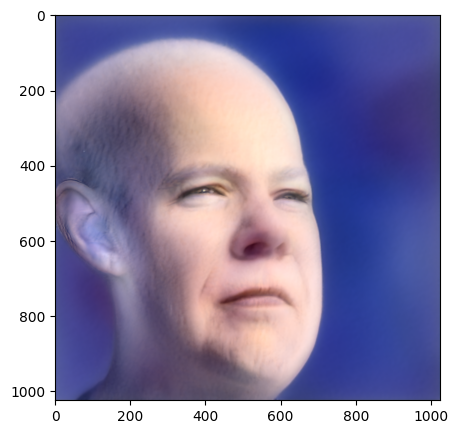

In [20]:
from PIL import Image
plot_image(generated_tensor, plot_size=(5,5))

In [25]:
def project_image(inv_img_path, num_steps = 150,
                   initial_learning_rate = 0.05,
                   w_avg_samples = 10000,
                    regularize_noise_weight = 5e5,
                    rec_weight = 0.5,
                    lpips_weight = 1,
                    seed = 42):
    target_pil = Image.open(inv_img_path).convert('RGB')
    target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()

    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    reg_loss = Reg_loss(noise_bufs)

    z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
    w_samples = G.mapping(z_samples, None)
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)   # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5
    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False)
    w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

    # w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) #

    optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
    generated_tensors = []
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()

        loss = lpips_value*lpips_weight + rec_value*rec_weight + reg_value*regularize_noise_weight

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        generated_tensors.append(synth_tensor)
    # save_image(generated_tensor, path="/content/pretrained_models/outer_imgs/projected_image.png")
    print(loss.item())
    return broadcast_w_sg(w_opt)



def project_image_e4e(image_path, num_steps = 150,
                   initial_learning_rate = 0.05,
                   w_avg_samples = 10000,
                    regularize_noise_weight = 5e5,
                    rec_weight = 0.5,
                    lpips_weight = 1,
                    seed = 42):
    e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

    #/content/stylegan2-ada-pytorch/pretrained_models/stylegan2-ada-pytorch
    target_pil = Image.open(image_path).convert('RGB')
    target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

    image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    target_pil = Image.open(image_path).convert('RGB')
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
    initial_latent_vector = e4e_model(e4e_tensor)

    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()

    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    reg_loss = Reg_loss(noise_bufs)


    num_steps = 100
    learning_rate = 0.01
    initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

    optimizer = torch.optim.Adam([initial_latent_vector], lr=learning_rate)
    generated_tensors = []
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(initial_latent_vector, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()

        loss = lpips_value*lpips_weight + rec_value*rec_weight + reg_value*regularize_noise_weight

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        generated_tensors.append(synth_tensor)

    #generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)

    # save_image(generated_tensor, path="/conrent/pretrained_models/outer_imgs/projected_image.png")
    print(loss.item())
    return target_tensor, initial_latent_vector

In [28]:
imgs_paths = [
    '/content/aligned_data/biden/0.jpg',
    '/content/aligned_data/trump/0.jpg'
]

imgs_to_plot = []
img_latents = []

for img_path in imgs_paths:

    latent_tensor_1 = project_image(img_path)
    generated_tensor_1 = G.synthesis(latent_tensor_1, noise_mode='const', force_fp32=True)

    init_img_tensor, latent_tensor_2 = project_image_e4e(img_path)
    img_latents.append(latent_tensor_2)
    generated_tensor_2 = G.synthesis(latent_tensor_2, noise_mode='const', force_fp32=True)

    vis_res = torch.cat((init_img_tensor, generated_tensor_1, generated_tensor_2), dim=3)
    imgs_to_plot.append(vis_res)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


114595.4609375
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


114595.390625
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [01:35<00:00,  1.57it/s]


114595.4453125
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


114595.3984375


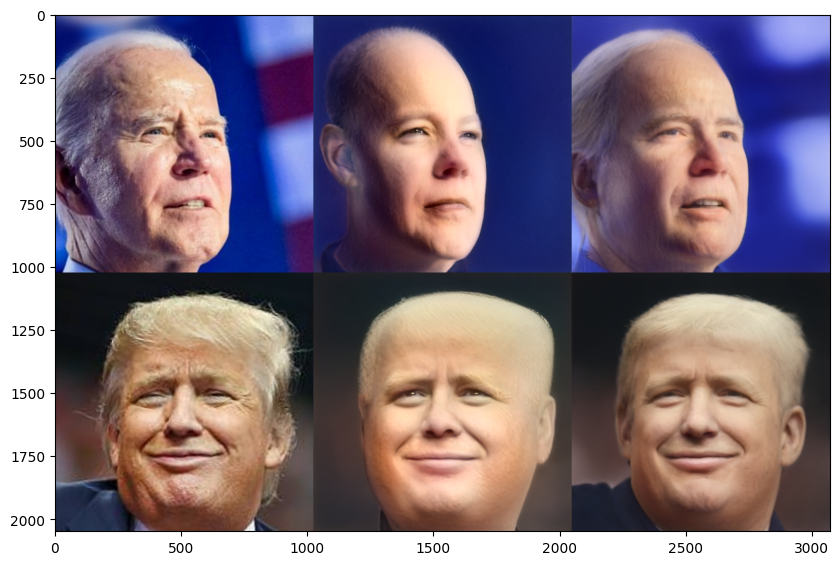

In [29]:
plot_images(imgs_to_plot, (10,14))

## Style transfer

In [30]:
os.makedirs('/content/styles/', exist_ok=True)

urls_styles= ['https://www.womensays.com/wp-content/uploads/2019/04/p0tat0_senpai_50924462_174735660165893_7675497633792786415_n-1-e1554854005601.jpg', 'https://th.bing.com/th/id/R.e4b4acf124f27806676e45326bf1addc?rik=MYcRLYpZRsssXQ&pid=ImgRaw&r=0', 'https://www.boredart.com/wp-content/uploads/2014/06/pop-art-andy-warhol-16-887x1024.png']

for enum, url in enumerate(urls_styles):
  destination = os.path.join('/content/styles', f'style_{enum}.jpg')
  download_image(url, destination)

In [31]:
raw_img_path = '/content/styles/style_1.jpg'
for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
    aligned_face_path = '/content/styles/style_1_aligned.jpg'
    image_align(raw_img_path, aligned_face_path, face_landmarks)
    break

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


114595.4609375


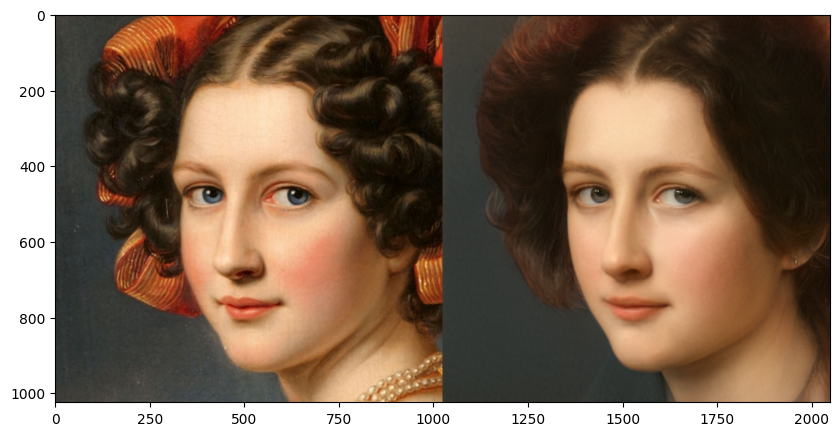

In [32]:
init_img_tensor, style_latent = project_image_e4e('/content/styles/style_1_aligned.jpg')
generated_tensor = G.synthesis(style_latent, noise_mode='const', force_fp32=True)
vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
plot_image(vis_res, (10,10))

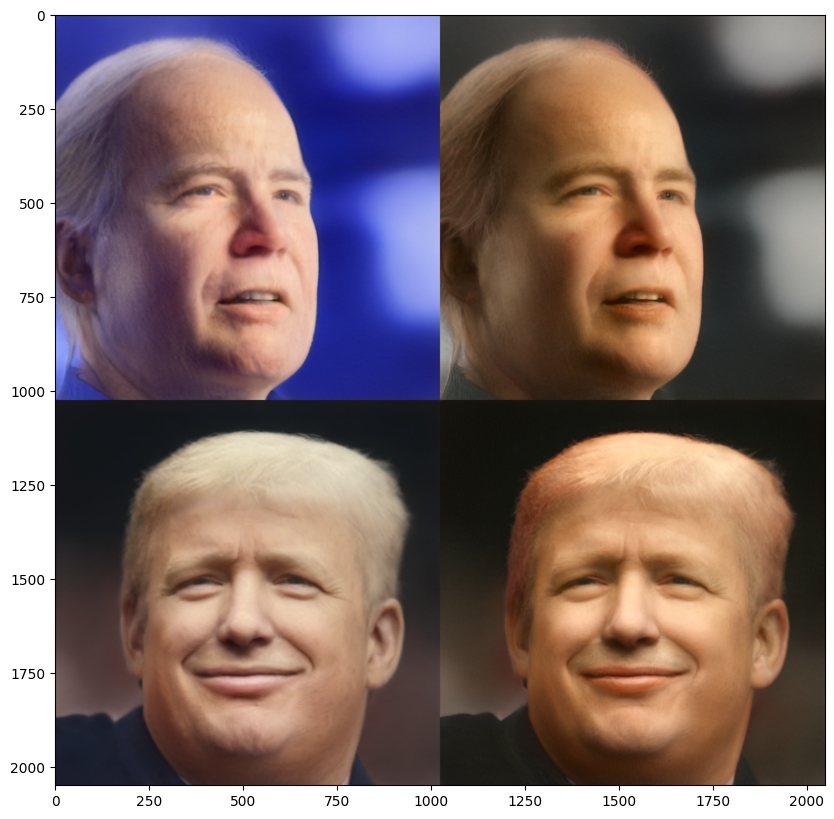

In [33]:
def styles_crossover(latent1, latent2, swap_dim_idxs=list(range(6))):
    latent1 = latent1.clone()
    for i in swap_dim_idxs:
        latent1[:, i] = latent2[:, i]
    return latent1

imgs_to_plot = []

for latent in img_latents:
    styled_latent = styles_crossover(latent, style_latent, list(range(10, 18)))
    styled_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
    generated_tensor = G.synthesis(latent, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((generated_tensor, styled_tensor), dim=3)
    imgs_to_plot.append(vis_res)


plot_images(imgs_to_plot, (10,10))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


114595.4609375


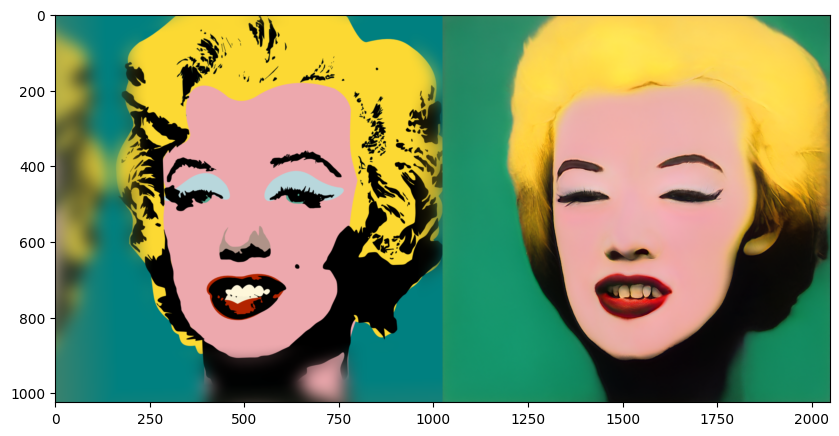

In [34]:
raw_img_path = '/content/styles/style_2.jpg'
for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
    aligned_face_path = '/content/styles/style_2_aligned.jpg'
    image_align(raw_img_path, aligned_face_path, face_landmarks)
    break

init_img_tensor, style_latent = project_image_e4e(aligned_face_path)
generated_tensor = G.synthesis(style_latent, noise_mode='const', force_fp32=True)
vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
plot_image(vis_res, (10,10))

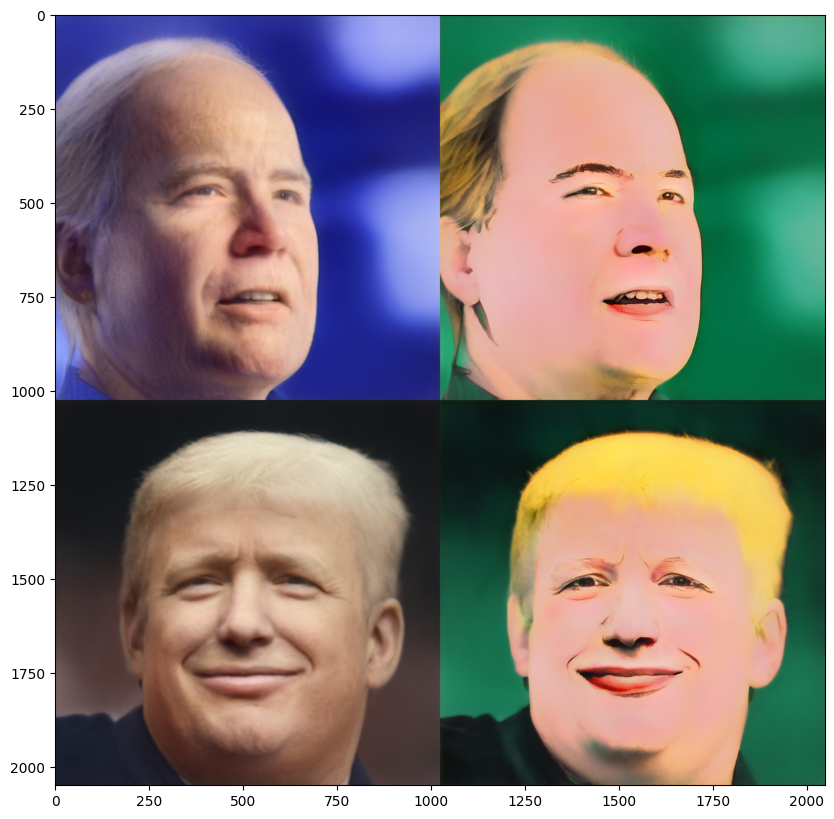

In [35]:
imgs_to_plot = []

for latent in img_latents:
    styled_latent = styles_crossover(latent, style_latent, list(range(9, 18)))
    styled_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
    generated_tensor = G.synthesis(latent, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((generated_tensor, styled_tensor), dim=3)
    imgs_to_plot.append(vis_res)



plot_images(imgs_to_plot, (10,10))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


114595.46875


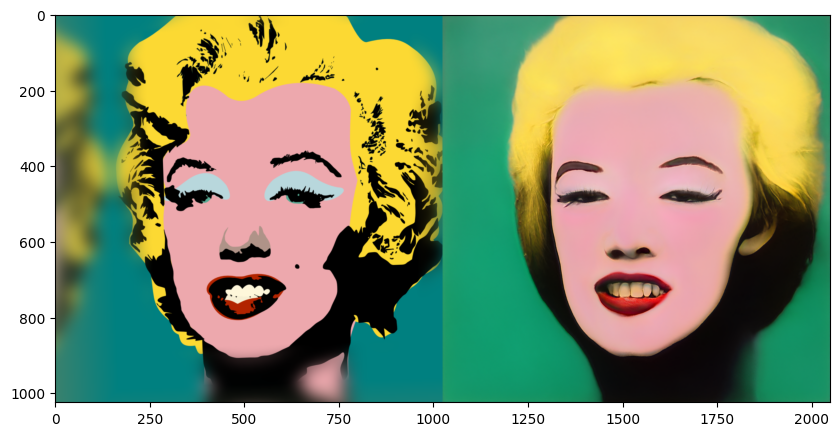

In [37]:
raw_img_path = '/content/styles/style_0.jpg'
for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
    aligned_face_path = '/content/styles/style_0_aligned.jpg'
    image_align(raw_img_path, aligned_face_path, face_landmarks)
    break

init_img_tensor, style_latent = project_image_e4e(aligned_face_path)
generated_tensor = G.synthesis(style_latent, noise_mode='const', force_fp32=True)
vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
plot_image(vis_res, (10,10))

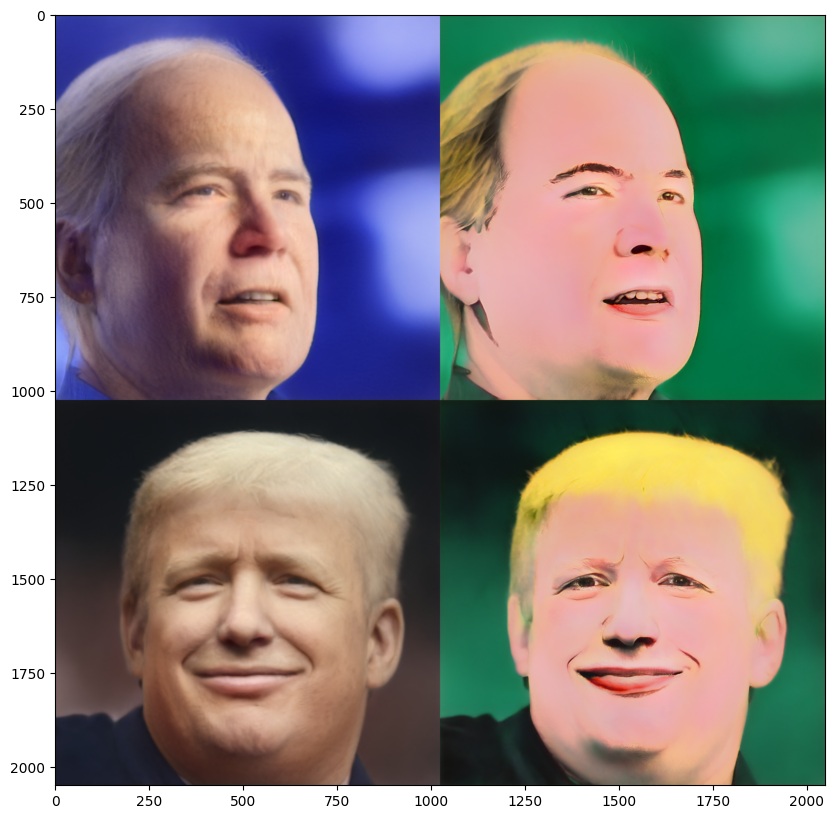

In [38]:
imgs_to_plot = []

for latent in img_latents:
    styled_latent = styles_crossover(latent, style_latent, list(range(9, 18)))
    styled_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
    generated_tensor = G.synthesis(latent, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((generated_tensor, styled_tensor), dim=3)
    imgs_to_plot.append(vis_res)



plot_images(imgs_to_plot, (10,10))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


114595.3984375


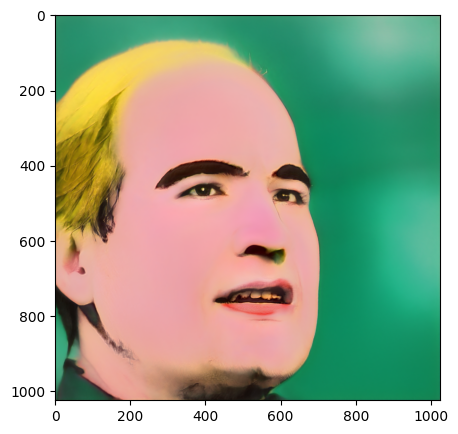

In [40]:
latent_tensor = project_image_e4e('/content/aligned_data/biden/0.jpg')[1]
styled_latent = styles_crossover(latent_tensor, style_latent, list(range(8, 18)))
generated_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
plot_image(generated_tensor, (5,5))

## Expression transfer

In [41]:
def interpolate(latent1, latent2, psi=0.5, indeces=[i for i in range(0,18)]):
    init_latent = latent1.clone()
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    edited_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    init_tensor = G.synthesis(init_latent, noise_mode='const', force_fp32=True)
    return init_tensor, edited_tensor
    #plot_image(torch.cat((init_tensor, edited_tensor ), dim=3), (10,10))

## Face Swap

In [42]:
!wget https://drive.google.com/file/d/1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5/view?usp=sharing

--2024-04-23 07:35:59--  https://drive.google.com/file/d/1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.251.12.102, 142.251.12.100, 142.251.12.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.12.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  83.57K  --.-KB/s    in 0.02s   

2024-04-23 07:36:00 (3.90 MB/s) - ‘view?usp=sharing’ saved [85576]



In [43]:
class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

arcface_path = "/content/ms1mv3_arcface_r50_fp16.pth"
attr_path  = "/content/aligned_data/trump/0.jpg"
id_path = "/content/aligned_data/biden/0.jpg"

In [46]:
def project_image_e4e_ARC(image_path, id_image_path, num_steps = 150,
                    initial_learning_rate = 0.05,
                    w_avg_samples = 10000,
                    regularize_noise_weight = 5e5,
                    rec_weight = 0.5,
                    lpips_weight = 1,
                    arcface_weight = 0.5,
                    seed = 42):
    e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

    target_pil = Image.open(image_path).convert('RGB')
    target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

    id_pil = Image.open(id_image_path).convert('RGB')
    id_image_tensor = image2tensor_norm(id_pil).to(device).unsqueeze(0)

    image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    target_uint8 = np.array(target_pil, dtype=np.uint8)

    e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
    initial_latent_vector = e4e_model(e4e_tensor)

    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()
    arcface_loss = Arcface_Loss(arcface_path, device)

    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    reg_loss = Reg_loss(noise_bufs)


    num_steps = 100
    learning_rate = 0.01
    initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

    optimizer = torch.optim.Adam([initial_latent_vector], lr=learning_rate)
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(initial_latent_vector, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()
        identity_loss = arcface_loss(id_image_tensor, synth_tensor)

        loss = lpips_value*lpips_weight + rec_value*rec_weight + reg_value*regularize_noise_weight + identity_loss*arcface_weight

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()


    print(loss.item())
    return target_tensor, initial_latent_vector

In [48]:
latent_tensor = project_image_e4e_ARC(image_path="/content/aligned_data/trump/0.jpg", id_image_path="/content/aligned_data/biden/0.jpg")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


114595.484375


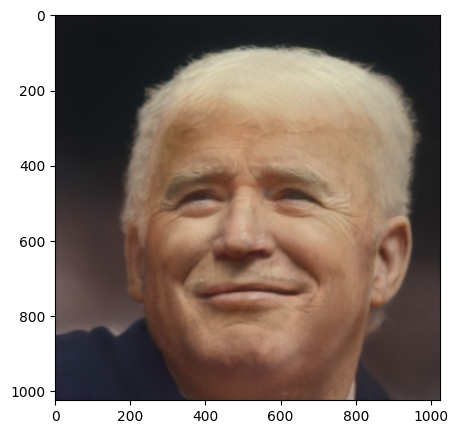

In [49]:
generated_tensor = G.synthesis(latent_tensor[1], noise_mode='const', force_fp32=True)
plot_image(generated_tensor, (5,5))

In [52]:
from torchvision.utils import save_image
import gc

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

os.makedirs('/content/generated_images/', exist_ok=True)

image_paths = [
    "/content/aligned_data/trump/0.jpg",
    "/content/aligned_data/biden/0.jpg",
    "/content/aligned_data/johnson/0.jpg"
]

In [53]:
for i, image_path in enumerate(image_paths):
    for j, id_image_path in enumerate(image_paths):
        if image_path != id_image_path:

            name_attr = image_path.split('/')[-2]
            name_id = id_image_path.split('/')[-2]

            clear_memory()  # Очистка памяти
            latent_tensor = project_image_e4e_ARC(image_path=image_path,
                                      id_image_path=id_image_path)[1]
            generated_tensor = G.synthesis(latent_tensor, noise_mode='const', force_fp32=True)
            generated_tensor = (generated_tensor + 1) / 2

            generated_tensor.clamp_(0, 1)

            save_image(generated_tensor, f'/content/generated_images/{name_attr}_as_{name_id}.png')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


114595.4921875
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


114595.5
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


114595.5
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


114595.5
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


114595.46875
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


114595.4765625


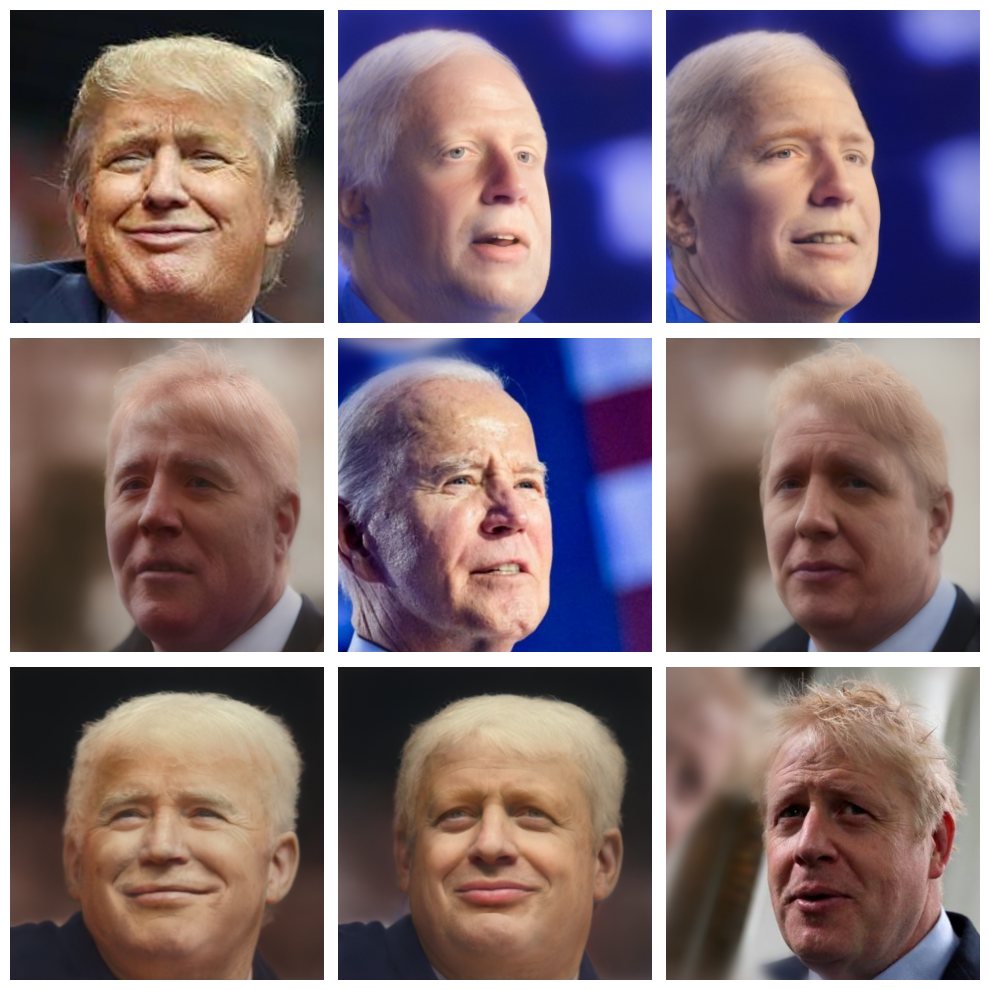

In [54]:
image_dir = '/content/generated_images'
image_files = [os.path.join(image_dir, image) for image in os.listdir(image_dir) if image.endswith('.png')]

image_files.sort()

diagonal_image_paths = [
    "/content/aligned_data/trump/0.jpg",
    "/content/aligned_data/biden/0.jpg",
    "/content/aligned_data/johnson/0.jpg"
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes_flat = axes.flatten()
image_index = 0

for i, ax in enumerate(axes_flat):
    if i % 4 == 0:
        diagonal_image = Image.open(diagonal_image_paths[i // 4])
        ax.imshow(diagonal_image)
    else:
        if image_index < len(image_files):
            image = Image.open(image_files[image_index])
            ax.imshow(image)
            image_index += 1

    ax.axis('off')

plt.tight_layout()
plt.show()